In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from cmap import Colormap
from monai.data.meta_obj import set_track_meta
from skimage.data import cells3d
from skimage.exposure import rescale_intensity
from torch.utils.benchmark import Measurement, Timer

torch.manual_seed(42)

img = rescale_intensity(cells3d(), out_range=(0, 1))

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(device))
else:
    device = torch.device("cpu")

x = torch.from_numpy(img).permute(1, 0, 2, 3).float().to(device).unsqueeze(0).repeat(64, 1, 1, 1, 1)
print(x.shape)

<frozen importlib._bootstrap_external>:1329: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


Using GPU: NVIDIA A40
torch.Size([64, 2, 60, 256, 256])


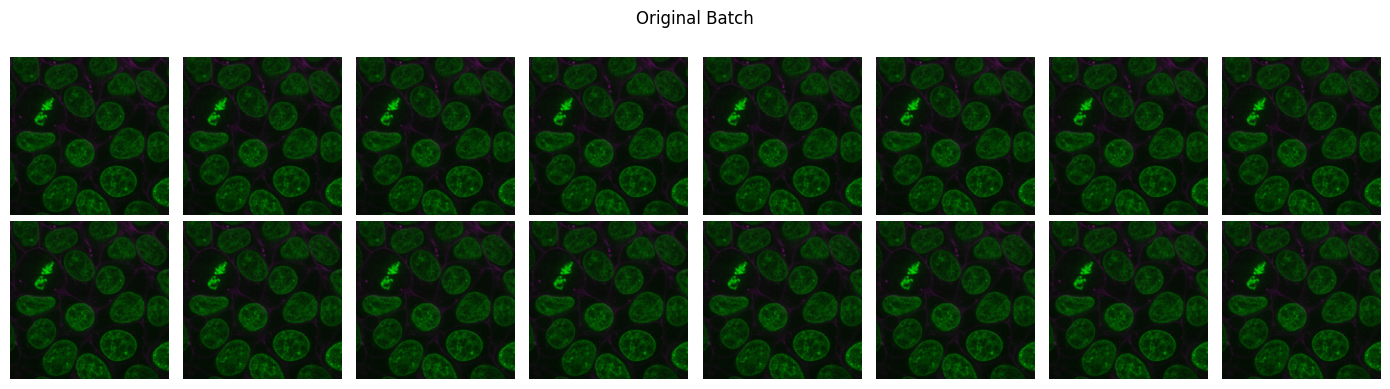

In [3]:
def blend_channels(image: np.ndarray, cmaps: list, rescale: bool = True) -> np.ndarray:
    """Blend multiple image channels into an RGB image using colormaps."""
    rendered_channels = []
    for channel, cmap in zip(image, cmaps):
        colormap = Colormap(cmap)
        if rescale:
            channel = rescale_intensity(channel, in_range="image", out_range=(0, 1))
        rendered_channels.append(colormap(channel))
    return np.sum(rendered_channels, axis=0).clip(0, 1)


def plot_batch(batch: torch.Tensor, slice: int | None = None, title: str = ""):
    if slice is None:
        slice = batch.shape[2] // 2
    batch = batch[:, :, slice].detach().cpu().numpy()
    fig, axes = plt.subplots(2, 8, figsize=(14, 4))
    for i, ax in enumerate(axes.flat):
        blended = blend_channels(batch[i], cmaps=["magenta", "green"], rescale=False)
        ax.imshow(blended, cmap="gray")
        ax.axis("off")
    fig.suptitle(title)
    fig.tight_layout()


plot_batch(x, title="Original Batch")

In [4]:
@torch.inference_mode()
def run_monai(x, monai_transform):
    set_track_meta(False)
    results = []
    for sample in x:
        cropped = monai_transform(sample)
        results.append(cropped)
    return torch.stack(results)


@torch.inference_mode()
def run_batched(x, batched_transform):
    return batched_transform(x)


def seconds_to_closest_unit(s: float) -> str:
    if s < 1e-6:
        return f"{s * 1e9:.2f} ns"
    elif s < 1e-3:
        return f"{s * 1e6:.2f} µs"
    elif s < 1:
        return f"{s * 1e3:.2f} ms"
    else:
        return f"{s:.2f} s"


def format_timer(measurement: Measurement) -> str:
    median = seconds_to_closest_unit(measurement.median)
    return f"{measurement.label}\n median={median}, n={measurement.number_per_run}"


def time_and_plot_transforms(x, monai_transform, batched_transform, n_iter: int = 5):
    monai_timer = Timer(
        label="MONAI",
        stmt="run_monai(x, monai_transform)",
        globals={"x": x, "monai_transform": monai_transform, "run_monai": run_monai},
        num_threads=8,
    )
    batched_timer = Timer(
        label="Batched",
        stmt="run_batched(x, batched_transform)",
        globals={
            "x": x,
            "batched_transform": batched_transform,
            "run_batched": run_batched,
        },
        num_threads=8,
    )
    print(format_timer(monai_timer.timeit(n_iter)))
    plot_batch(run_monai(x, monai_transform), title="monai")
    plt.show()
    print(format_timer(batched_timer.timeit(n_iter)))
    plot_batch(run_batched(x, batched_transform), title="batched")

MONAI
 median=8.59 ms, n=5


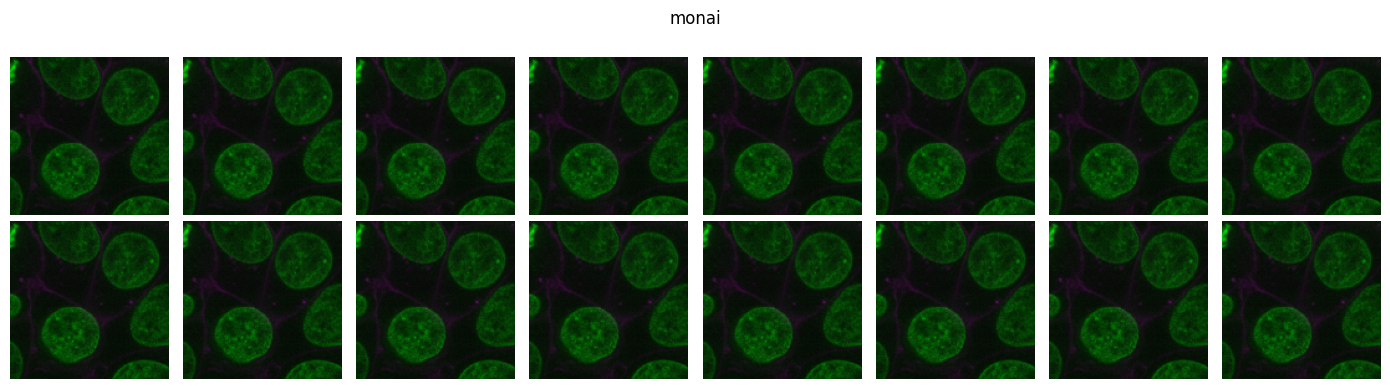

Batched
 median=95.55 µs, n=5


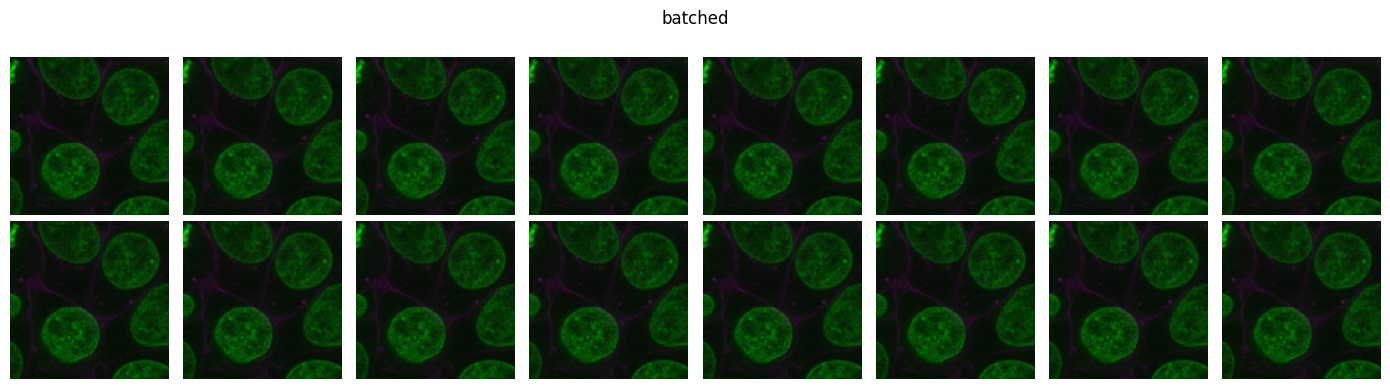

In [5]:
from monai.transforms import CenterSpatialCrop

from viscy_transforms import BatchedCenterSpatialCrop

center_crop = CenterSpatialCrop(roi_size=(128, 128, 128))
batched_center_crop = BatchedCenterSpatialCrop(roi_size=(128, 128, 128))

time_and_plot_transforms(x, center_crop, batched_center_crop)

MONAI
 median=10.83 ms, n=5


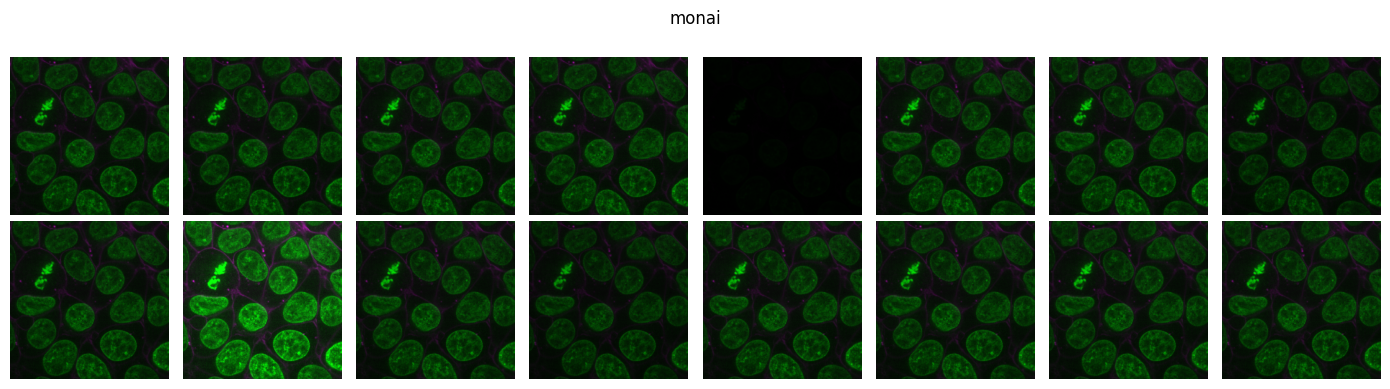

Batched
 median=7.19 ms, n=5


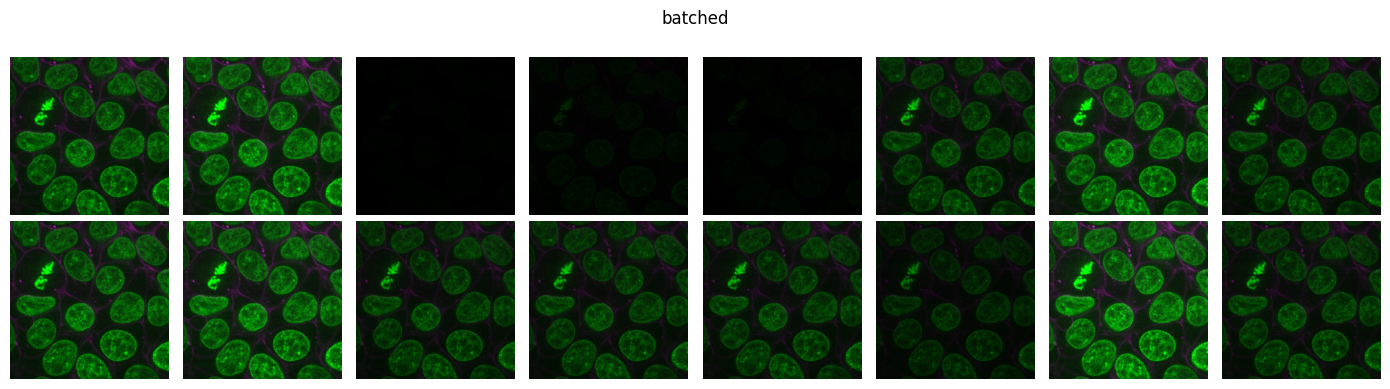

In [6]:
from monai.transforms import RandScaleIntensity

from viscy_transforms import BatchedRandScaleIntensity

random_scale_intensity = RandScaleIntensity(prob=0.5, factors=1.0)
batched_random_scale_intensity = BatchedRandScaleIntensity(prob=0.5, factors=1.0)

time_and_plot_transforms(x, random_scale_intensity, batched_random_scale_intensity)

MONAI
 median=40.42 ms, n=5


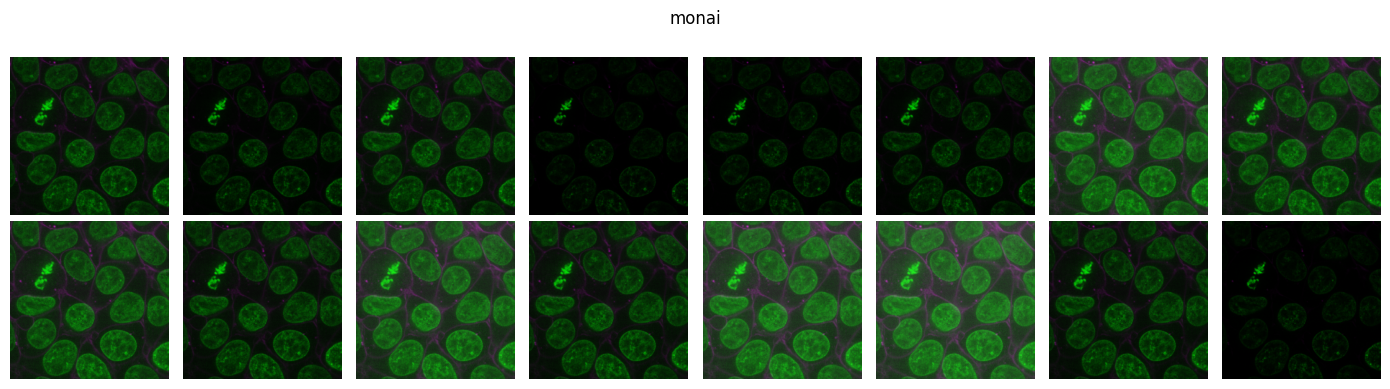

Batched
 median=41.52 ms, n=5


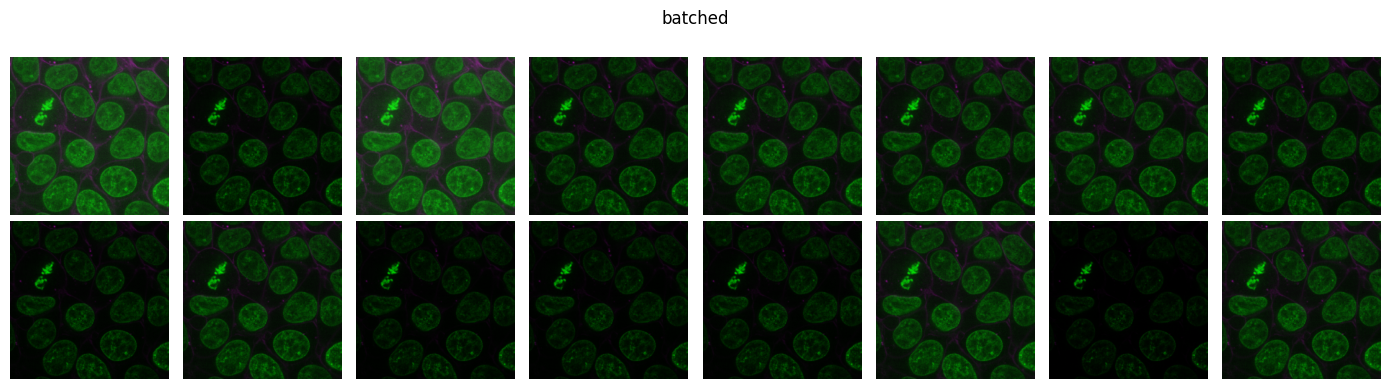

In [7]:
from monai.transforms import RandAdjustContrast

from viscy_transforms import BatchedRandAdjustContrast

random_gamma = RandAdjustContrast(gamma=(0.5, 2.0), prob=0.75)
batched_random_gamma = BatchedRandAdjustContrast(gamma=(0.5, 2.0), prob=0.75)

time_and_plot_transforms(x, random_gamma, batched_random_gamma)

MONAI
 median=91.22 ms, n=5


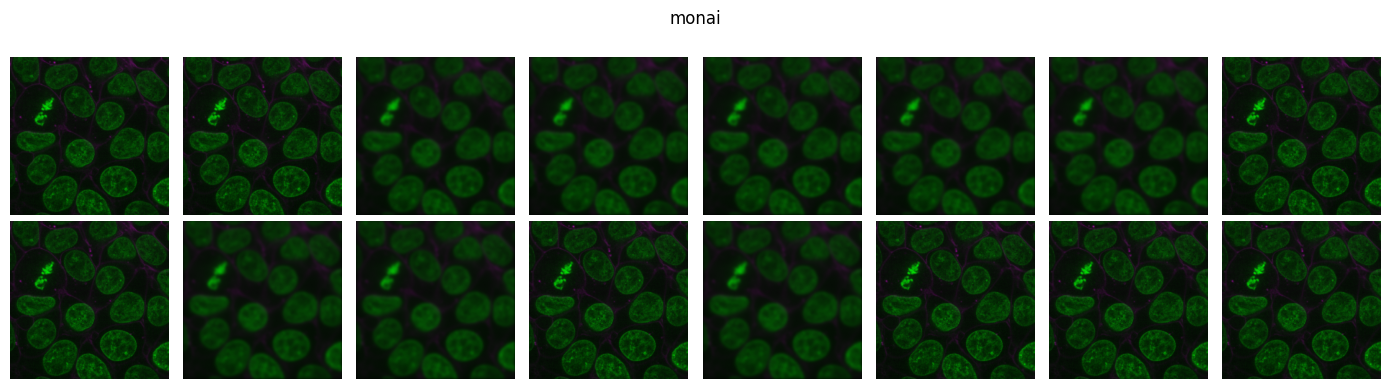

Batched
 median=71.28 ms, n=5


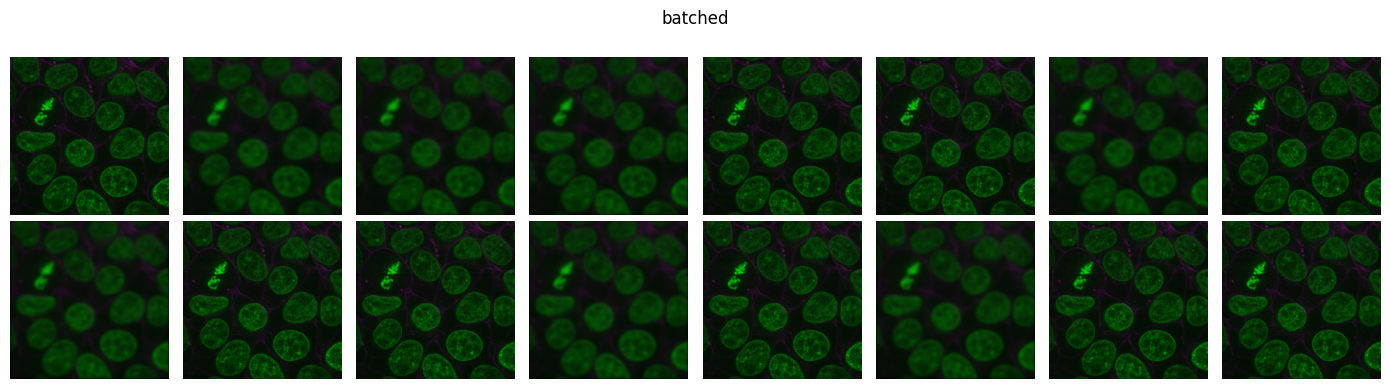

In [8]:
from monai.transforms import RandGaussianSmooth

from viscy_transforms import BatchedRandGaussianSmooth

sigma = (2.0, 2.0)

rand_gaussian_smooth = RandGaussianSmooth(sigma_x=sigma, sigma_y=sigma, sigma_z=sigma, prob=0.5)

batched_rand_gaussian_smooth = BatchedRandGaussianSmooth(
    sigma_x=sigma, sigma_y=sigma, sigma_z=sigma, prob=0.5, truncated=3.0
)

time_and_plot_transforms(x, rand_gaussian_smooth, batched_rand_gaussian_smooth)

MONAI
 median=14.93 ms, n=5


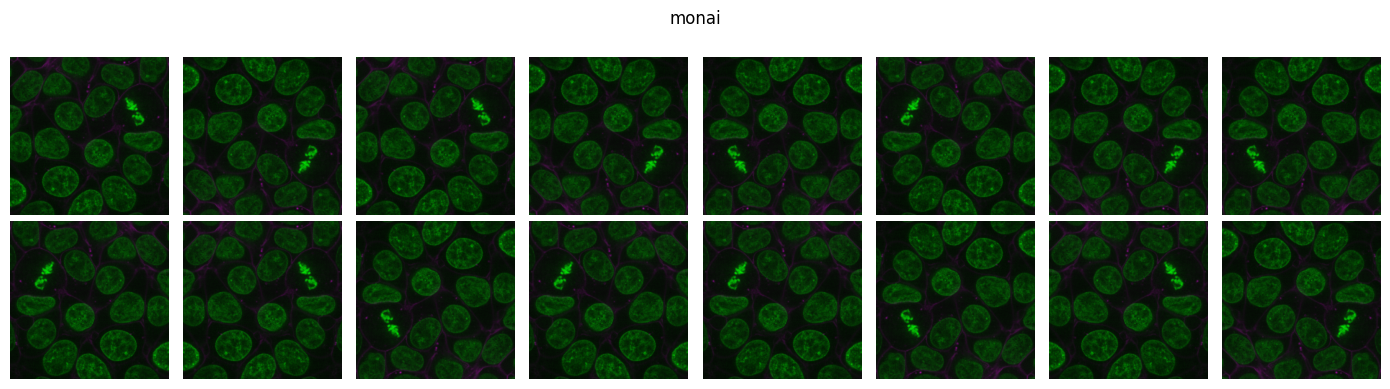

Batched
 median=16.28 ms, n=5


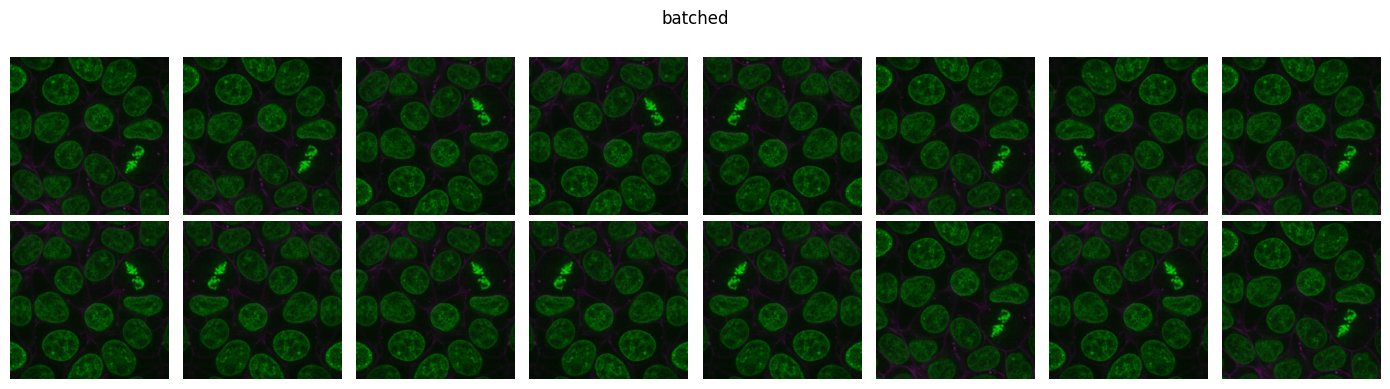

In [9]:
from monai.transforms import Compose, RandFlip

from viscy_transforms import BatchedRandFlip

random_flip = Compose([RandFlip(prob=0.5, spatial_axis=1), RandFlip(prob=0.5, spatial_axis=2)])
batched_random_flip = BatchedRandFlip(prob=0.5, spatial_axes=[1, 2])

time_and_plot_transforms(x, random_flip, batched_random_flip)

MONAI
 median=4.05 ms, n=5


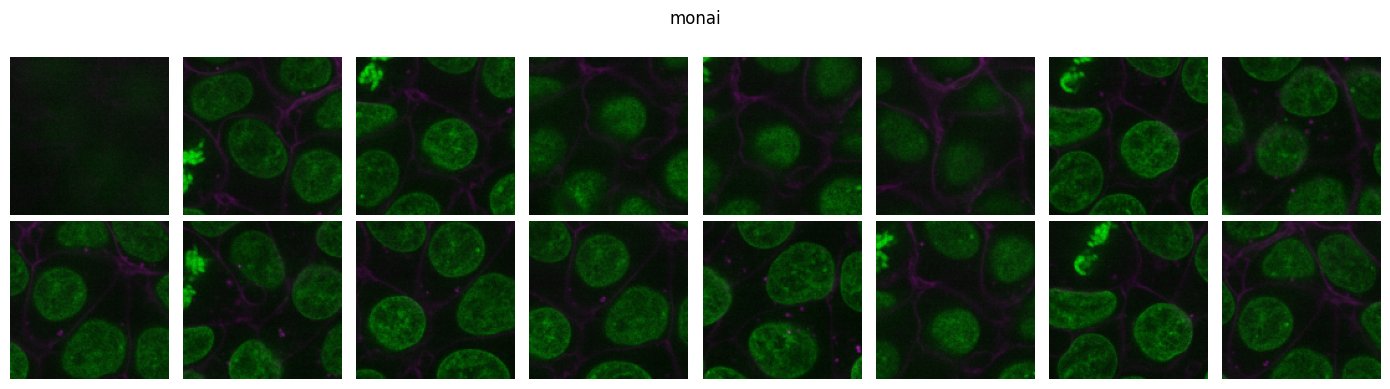

Batched
 median=1.30 ms, n=5


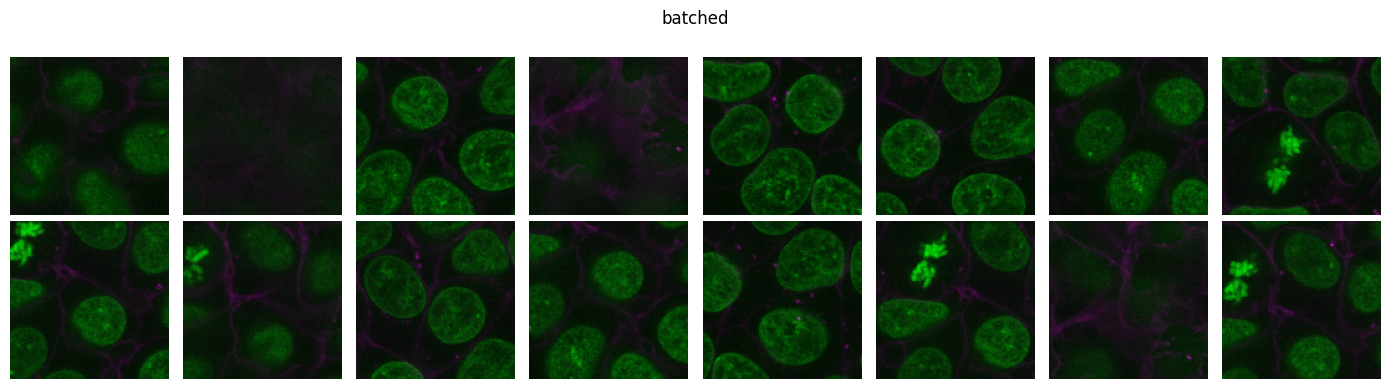

In [10]:
from monai.transforms import RandSpatialCrop

from viscy_transforms import BatchedRandSpatialCrop

rand_spatial_crop = RandSpatialCrop(roi_size=(32, 128, 128), random_center=True)
batched_rand_spatial_crop = BatchedRandSpatialCrop(roi_size=(32, 128, 128), random_center=True)

time_and_plot_transforms(x, rand_spatial_crop, batched_rand_spatial_crop)

MONAI
 median=8.32 s, n=5


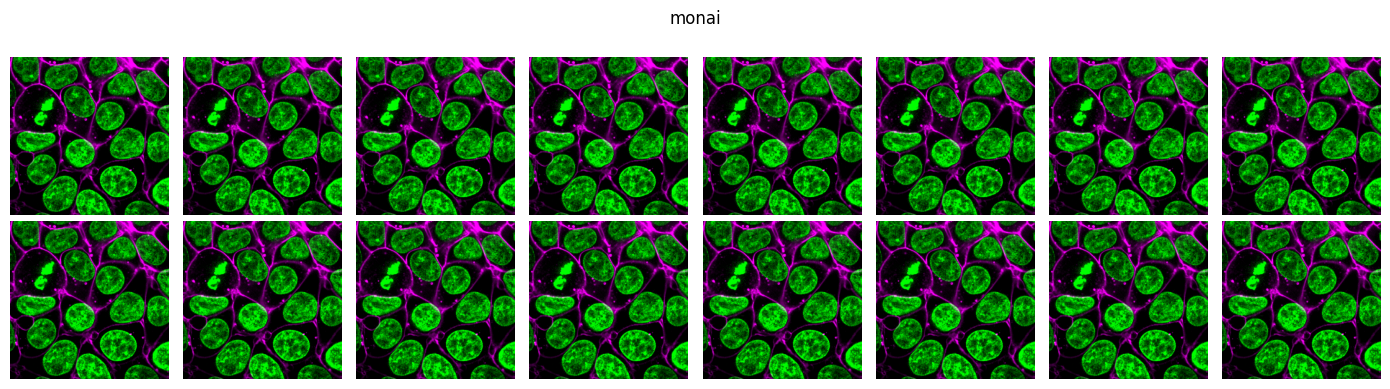

Batched
 median=156.46 ms, n=5


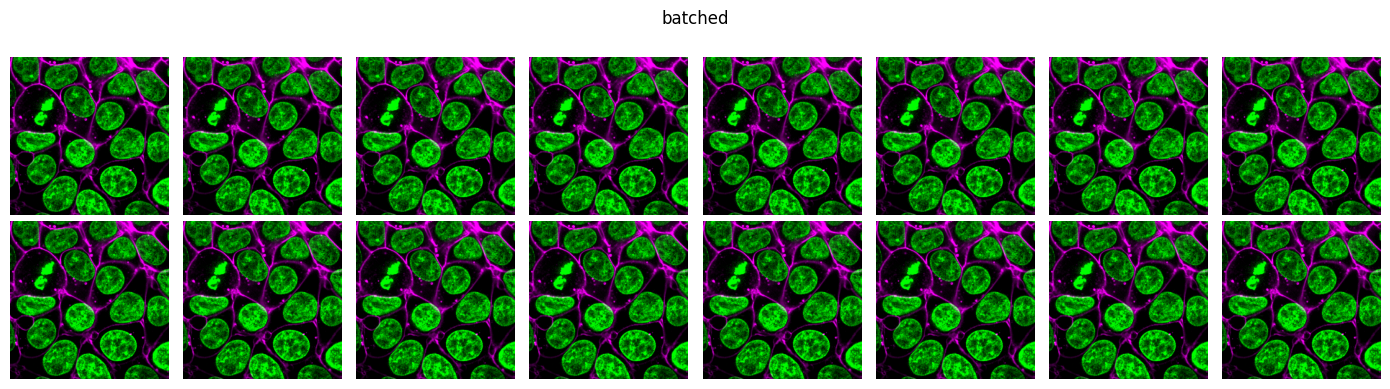

In [11]:
from monai.transforms import ScaleIntensityRangePercentiles

from viscy_transforms import BatchedScaleIntensityRangePercentiles

scale_intensity_range_percentiles = ScaleIntensityRangePercentiles(
    lower=50.0, upper=99.0, b_min=0.0, b_max=1.0, channel_wise=True
)
batched_scale_intensity_range_percentiles = BatchedScaleIntensityRangePercentiles(
    lower=50.0, upper=99.0, b_min=0.0, b_max=1.0, channel_wise=True
)

time_and_plot_transforms(x, scale_intensity_range_percentiles, batched_scale_intensity_range_percentiles)

MONAI
 median=13.35 s, n=5


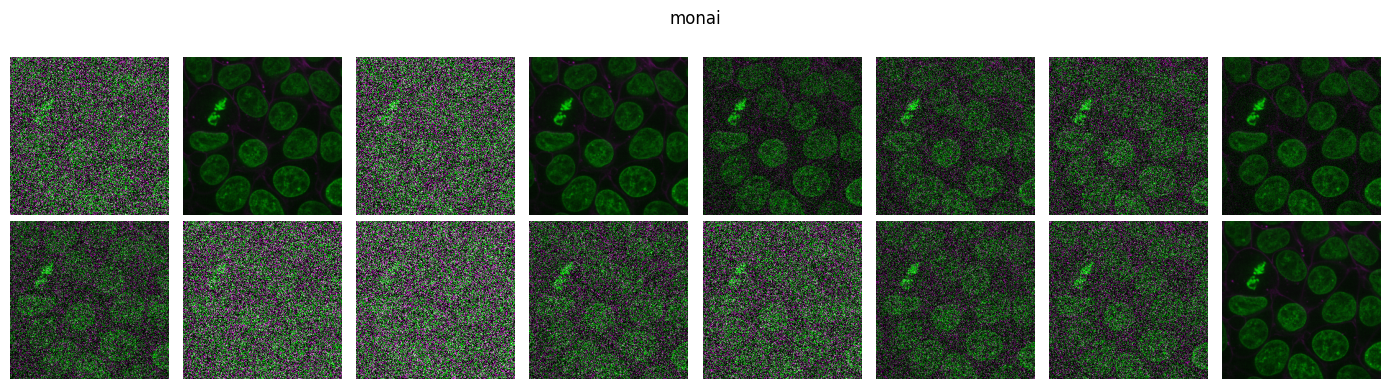

Batched
 median=22.51 ms, n=5


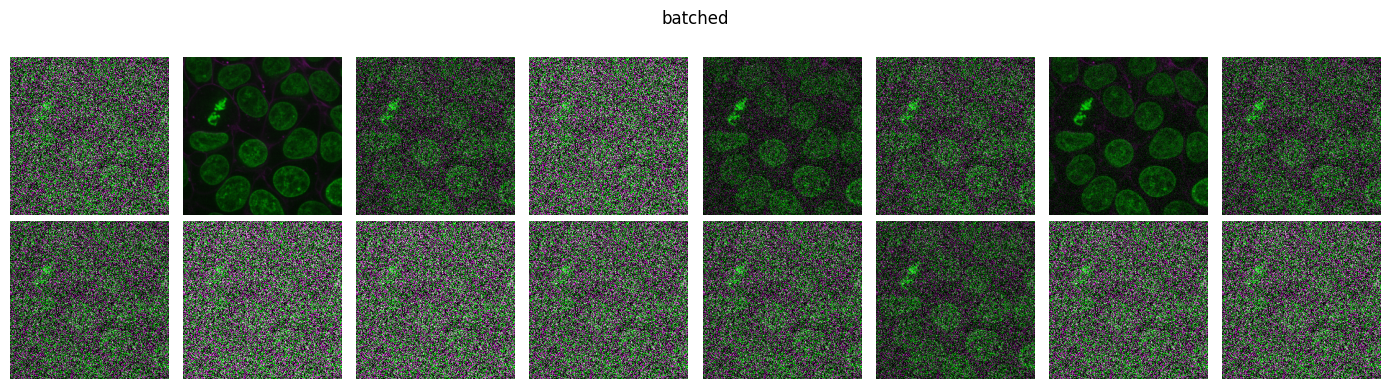

In [12]:
from monai.transforms import RandGaussianNoise

from viscy_transforms import BatchedRandGaussianNoise

rand_gaussian_noise = RandGaussianNoise(prob=0.75, mean=0.0, std=1.0)
batched_rand_gaussian_noise = BatchedRandGaussianNoise(prob=0.75, mean=0.0, std=1.0)

time_and_plot_transforms(x, rand_gaussian_noise, batched_rand_gaussian_noise)